# **Voyager Signal Similarity Search with β-VAE (Colab Tutorial)**

### Introduction

In this tutorial, we will use real Voyager-1 radio spectrogram data from the Breakthrough Listen public archive to demonstrate a content-based signal search. We aim to find signals that look morphologically similar to a given “query” signal in Voyager's spectrograms. The dataset consists of six 5-minute scans of Voyager 1 acquired by the Green Bank Telescope in July 2020 (3 scans pointed ON the Voyager spacecraft and 3 OFF target) 1 . For simplicity, we will ignore the ON/OFF labeling (i.e. we won’t perform interference filtering by removing OFF-target signals 2 ). Instead, we’ll treat all scans uniformly as a pool of spectrogram data in which to search for lookalike signals.

### Approach

We follow a simplified version of the method by Ma et al. (2024). First, we use an energy detection approach to extract small signal snippets from the full spectrogram – essentially finding time- frequency patches with power significantly above the noise floor 4 . These snippets (for example, containing narrowband Doppler-drifted carrier signals) will be our “catalog” of candidate signals. Next, we load a pretrained β-Variational Autoencoder (β-VAE) encoder model provided by Peter Ma et al. 3 . This neural network encodes each spectrogram snippet into a low-dimensional latent feature vector that captures its salient morphological features (shape, bandwidth, drift rate, etc.). Finally, given a selected query snippet, we compute the cosine similarity between the query’s embedding and all other snippet embeddings 5 to retrieve the most similar signals. We will display the top 10 matches as images and discuss the results.

### Requirements

This notebook uses TensorFlow (with GPU support) and common scientific Python packages (NumPy, h5py, etc.) which are pre-installed in Colab. We will also install Blimpy (Breakthrough Listen I/O toolkit) to help read .h5 spectrogram files. The β-VAE encoder model will be downloaded from Peter Ma’s GitHub repository and loaded with Keras.
Let's get started by importing necessary libraries and preparing the data.

## Setup and Data Loading

First, we install blimpy and explicitly downgrade pyparsing to avoid version conflicts.
This cell must run before any code that triggers a pyparsing import.
Note: Colab may silently preload pyparsing 3.x, so a runtime restart may still be needed after this.

In [1]:
%pip install blimpy==2.1.4 pyparsing==2.4.7

Next, let's clone the Github repo into this Google Colab runtime so that we have access to all the files we'll need and change into that directory:

In [2]:
!git clone https://github.com/elanlavie/VoyagerMLTutorial.git

import os
os.chdir('VoyagerMLTutorial')

fatal: destination path 'VoyagerMLTutorial' already exists and is not an empty directory.


Next, let's install Blimpy for reading the HDF5 (.h5) filterbank files, and import required libraries:

In [3]:
#!pip install blimpy # BL data reader library

import numpy as np
import h5py
from blimpy import Waterfall
import matplotlib.pyplot as plt

# Set matplotlib for inline plotting (if in Colab, this is usually automatic)
%matplotlib inline

Next, we assume the six Voyager .h5 files are available in the Colab environment (e.g. uploaded or in Drive). For example, they might be named like voyager1_scan11.h5, voyager1_scan12.h5, ... voyager1_scan16.h5 corresponding to the 3 ON + 3 OFF scans (scans 11, 13, 15 are ON; 12, 14, 16 are OFF) 1 2 . We will list the files and load them one by one to build our snippet catalog. Each file contains a **spectrogram** (waterfall plot) of one 5-min scan: power as a function of time and frequency. The time resolution in these files is on the order of 10–18 seconds per bin (the data here use ~10.7 s integration) and frequency resolution ~2.79 Hz per bin 6 .

We'll iterate through each file, read its data, and identify high-energy patches. For this simple energy detector, we define a patch (snippet) as a fixed frequency bandwidth of ~715 Hz (which is 256 frequency bins at 2.79 Hz resolution 7 8 ) across the full time span of the scan. We slide this 256-bin window across the band and extract a snippet whenever the window contains a signal above a set threshold. The threshold can be set as, for example, mean + 5σ of the noise power. This approach will catch narrowband signals that
stand out above noise in that frequency interval (as used in Ma et al. for initial energy detection.

Let's implement the snippet extraction:

In [4]:
# You can edit this variable to match whichever directory you will use to store your data files
data_directory = 'voyager_2020_data'

# Read the necessary URLs from data_urls.lst
with open('data_urls.lst') as file:
    data_urls = file.read().splitlines()

# Local imports
import download_progress

# Download each one into a directory called 'data' if they aren't already present.
for url in data_urls:
    download_progress.download_file_with_progress_bar(url, download_dir=data_directory)

File 'voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5' already exists - not re-downloading http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5
File 'voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5' already exists - not re-downloading http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5
File 'voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5' already exists - not re-downloading http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5
File 'voyager_2020_data/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5' already exists - not re-downloading http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_gu

In [5]:
# List your Voyager .h5 files (update the pattern if needed)
import glob
file_list = sorted(glob.glob("voyager_2020_data/*.h5"))
print("Found files:", file_list)

snippets = []        # to store extracted snippet arrays
snippet_locs = []    # to store metadata (file name and freq range of each snippet)

# Parameters
freq_window = 256  # number of frequency bins ~715 Hz
sigma_threshold = 5.0  # threshold in terms of noise standard deviation

for fname in file_list:
    # Load the spectrogram data using blimpy
    wf = Waterfall(fname, load_data=True)
    data = wf.data.squeeze()  # shape: (time_bins, freq_bins)
    print(f"{fname}: data shape = {data.shape}")
    # Estimate noise level from the whole scan (assuming most of it is noise)
    mean_noise = np.mean(data)
    std_noise = np.std(data)
    threshold = mean_noise + sigma_threshold * std_noise
    # Slide a window of 256 frequency bins and extract patches exceeding threshold
    n_freq = data.shape[1]
    for f_start in range(0, n_freq, freq_window):
        f_end = min(f_start + freq_window, n_freq)
        patch = data[:, f_start:f_end]  # all time, slice of freq
        if patch.max() > threshold:
          # Extract the patch covering all time bins and this freq range
          snippets.append(patch.copy())
          snippet_locs.append((fname, f_start, f_end))
    del data  # free memory for next file

Found files: ['voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5', 'voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5', 'voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5', 'voyager_2020_data/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5', 'voyager_2020_data/single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5', 'voyager_2020_data/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.h5']
voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5: data shape = (16, 1048576)
voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5: data shape = (16, 1048576)
voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5: data shape = (16, 1048576)
voyager_2020_data/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5: data shape = (16, 10485

When this loop runs, it will output the shape of each file's data array (time × frequency) and accumulate any snippet that contains a significant signal. The threshold is tuned to pick up obvious narrowband signals like Voyager's carrier or strong RFI lines, while ignoring pure noise regions.

**Note:** In these Voyager scans, the spacecraft’s carrier signal is clearly visible in the ON-source scans as a faint drifting tone 9 , whereas OFF scans contain only noise. Our simple detector should catch the Voyager carrier in ON scans and might also capture any prominent terrestrial RFI peaks if present. The snippet size (256 freq bins) is chosen to cover the typical width of narrowband signals; Voyager’s carrier drifts by a few hundred Hz over 5 minutes 10 , which falls within this window. Time-wise, we include the full duration of the scan for each snippet, so each snippet is essentially a vertical time-frequency slice ~5 minutes long by 715 Hz wide.

Let’s verify that we extracted some snippets and examine one for sanity. We expect at least one snippet corresponding to Voyager’s carrier. We'll print the number of snippets and visualize an example snippet (e.g., the first one):

Running the below will display a spectrogram patch. For instance, if the selected snippet is the Voyager carrier, you would see a narrow drifting line indicating the signal sweeping through frequency over time (due to Doppler drift) against a low-noise background.

Total snippets extracted: 17


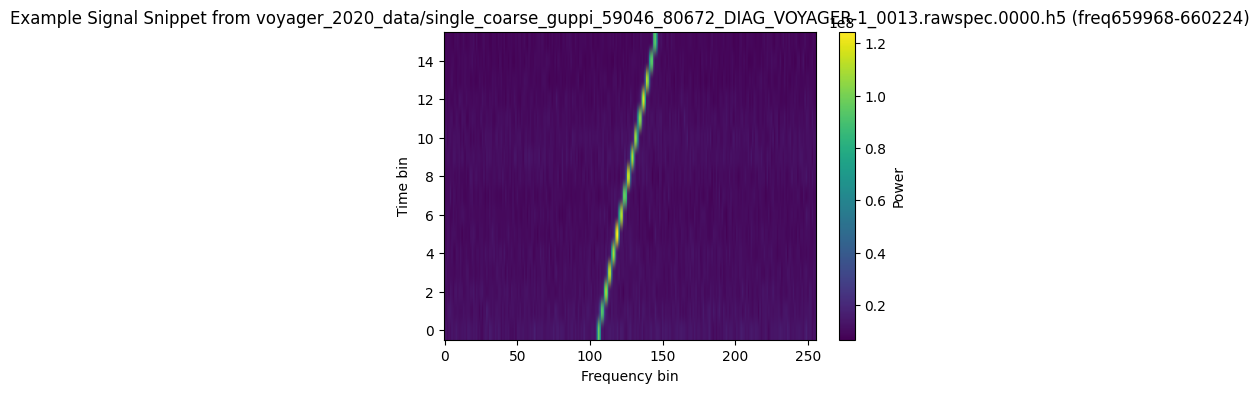

In [6]:
print(f"Total snippets extracted: {len(snippets)}")
  # Plot an example snippet (e.g., ninth snippet so idx = 8)
if snippets:
  idx = 8
  example = snippets[idx]
  plt.figure(figsize=(6,4))
  plt.imshow(example, aspect='auto', origin='lower', cmap='viridis')
  plt.colorbar(label='Power')
  plt.title(f"Example Signal Snippet from {snippet_locs[idx][0]} (freq{snippet_locs[idx][1]}-{snippet_locs[idx][2]})")
  plt.xlabel("Frequency bin")
  plt.ylabel("Time bin")
  plt.show()

Example spectrogram snippet (waterfall plot) of Voyager 1's carrier signal over ~5 minutes. The narrow diagonal line is the spacecraft’s radio carrier drifting in frequency due to relative motion (Doppler *drift*). We will use such snippets as inputs to the VAE encoder.

## Loading the Pretrained β-VAE Encoder Model

Peter Ma and colleagues trained a β-VAE on millions of such signal snippets to learn a compressed representation of signal morphologies. Here we will load the pretrained encoder model (which maps a 2D spectrogram snippet to a latent feature vector). The model file is hosted on GitHub, and we can download it directly.

In [7]:
from tensorflow.keras.models import load_model
encoder = load_model("vae_encoder.keras")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 256, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 32, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,196,330 (4.56 MB)

 Trainable params: 1,196,266 (4.56 MB)

 Non-trainable params: 64 (256.00 B)

The encoder.summary() shows the layers of the model. It is a convolutional neural network that takes an input of shape (time, frequency, 1) – in our case, ~16 time bins × 256 freq bins × 1 channel – and outputs a latent vector (the encoded features). Note: The model expects a specific input shape that matches the training snippets. In the original paper, spectrograms were averaged to about 18.25 s per time bin, giving 16 time bins per 5-min snippet 11 . Our data has ~28 time bins (at ~10.7 s each) per snippet, which we need to adjust. To match the model, we will downsample each snippet’s time dimension to 16 bins.
For simplicity, we can do a rough downsampling by selecting 16 evenly spaced time slices from each snippet. (In a more rigorous approach, one could average or interpolate, but this quick method should retain the overall signal shape.) Let's prepare all snippets for input into the encoder:

In [8]:
# Prepare snippet array for model input
import math
snippets_array = []
for patch in snippets:
    t_bins, f_bins = patch.shape
    # Choose 16 time indices evenly from the snippet
    if t_bins >= 16:
        idx = np.linspace(0, t_bins-1, 16, dtype=int)
        patch_16 = patch[idx, :]
    else:
        # if somehow fewer than 16 (unlikely here), pad with last row
        pad_count = 16 - t_bins
        patch_16 = np.vstack([patch, np.tile(patch[-1,:], (pad_count, 1))])
    # Normalize or log-scale if needed (optional):
    # In practice, one might log10 transform and normalize each snippet as done in training.
# Here we assume the model was trained on linear power; we'll proceed without additional normalization.
    # Add channel dimension:
    patch_16 = np.expand_dims(patch_16, axis=-1)  # shape: 16 x 256 x 1
    snippets_array.append(patch_16)
snippets_array = np.array(snippets_array)
print("Input tensor shape for encoder:", snippets_array.shape)

Input tensor shape for encoder: (17, 16, 256, 1)


Now we pass this tensor through the encoder to get the latent embeddings for each snippet.

In [9]:
embeddings = encoder.predict(snippets_array)
print("Embeddings shape:", embeddings.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Embeddings shape: (17, 10)


After encoding, we have an array of embeddings ( embeddings ), where each row is the feature vector for
the   corresponding   snippet.   (For   example,   if   the   latent   space   dimension   is  d,   the   shape   will   be
(N_snippets, d) .)

## Similarity Search in Latent Space

With all snippets embedded into feature space, we can perform a reverse similarity search. We will pick
one snippet as our query – ideally a snippet containing a signal of interest (e.g. Voyager’s carrier) – and
compute the cosine similarity between this query vector and every other snippet’s vector . High cosine
similarity (near 1.0) means the candidate snippet’s spectrogram looks very similar to the query; low
similarity means they differ. We then rank all snippets by similarity and take the top 10 matches (excluding
the query itself).

Let's choose the first snippet as the query (you could pick any index corresponding to a known signal). Then
compute similarities and find the top matches:

In [11]:
# Choose a query snippet (index 0 for example)
query_index = 0
query_vec = embeddings[query_index]
# Compute cosine similarity between query_vec and all embeddings
norms = np.linalg.norm(embeddings, axis=1)
query_norm = np.linalg.norm(query_vec)
cosine_sim = (embeddings @ query_vec) / (norms * query_norm) # dot product normalized
# Exclude the query itself and sort by similarity
cosine_sim[query_index] = -1 # set self-similarity to -1 to exclude it
top10_idx = cosine_sim.argsort()[-10:][::-1]
print("Top 10 similar snippet indices:", top10_idx)
print("Cosine similarities:", cosine_sim[top10_idx])

Top 10 similar snippet indices: [16 11 12  5  4 15  9 13  1  6]
Cosine similarities: [0.9999558  0.9999544  0.99993855 0.9998713  0.9989467  0.7655198
 0.70909667 0.68484104 0.68445534 0.67598075]


The above will give us the indices of the 10 most similar snippets to our query. Now, let's visualize the query
snippet and the top 10 matches side by side. This will help us verify that the retrieved snippets look similar
in morphology (narrowband, drifting, etc.) to the query signal, even if they occur at different frequencies or
times.

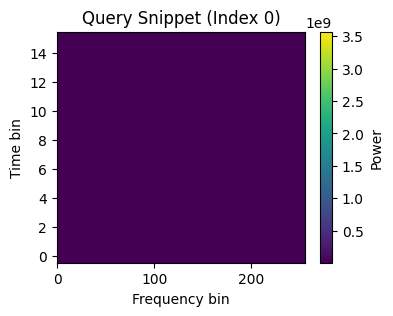

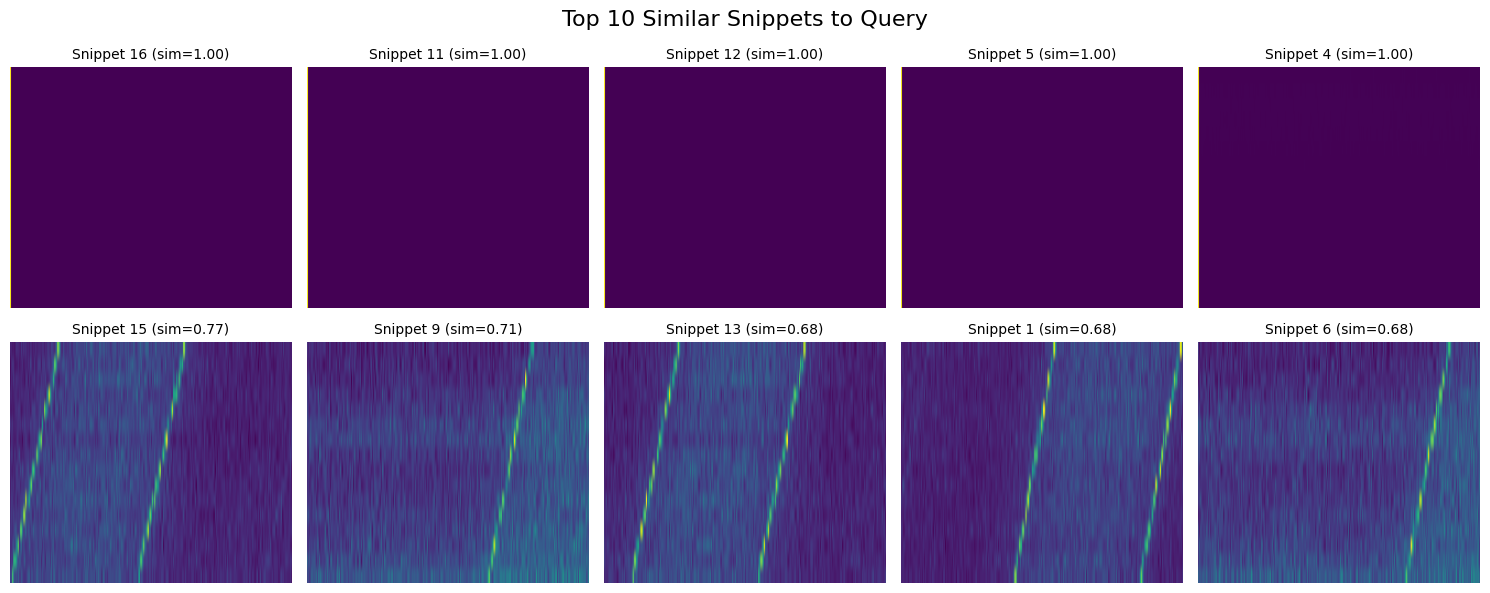

In [13]:
# Plot the query snippet and top 10 similar snippets
query_snip = snippets[query_index]
plt.figure(figsize=(4,3))
plt.imshow(query_snip, aspect='auto', origin='lower', cmap='viridis')
plt.title("Query Snippet (Index %d)" % query_index)
plt.xlabel("Frequency bin"); plt.ylabel("Time bin")
plt.colorbar(label='Power')
plt.show()
# Plot top 10 matches in a grid
fig, axs = plt.subplots(2, 5, figsize=(15,6))
for i, idx in enumerate(top10_idx):
  r, c = divmod(i, 5)
  ax = axs[r][c]
  ax.imshow(snippets[idx], aspect='auto', origin='lower', cmap='viridis')
  ax.set_title(f"Snippet {idx} (sim={cosine_sim[idx]:.2f})", fontsize=10)
  ax.axis('off')
plt.suptitle("Top 10 Similar Snippets to Query", fontsize=16)
plt.tight_layout()
plt.show()

After running the above, you should see a grid of 10 spectrogram patches. They are the snippets our
algorithm judged most similar to the query snippet. If our query was Voyager's carrier, the top matches will
likely include other appearances of the Voyager signal (if present in multiple scans) or other narrowband
signals with similar drift slopes.  Visually, we expect these retrieved snippets to all show narrow,
possibly drifting lines, as opposed to pure noise. This confirms that the β-VAE has learned to represent
the morphological signature of the signal in latent space, and clustering in that space correlates with
visual similarity.

For example, in Ma et al. (2024), using a similar β-VAE approach without frequency metadata, the algorithm
successfully returned convincing lookalike signals—narrowband streaks—while avoiding random noise
matches . By using cosine similarity on the encoded features, we efficiently retrieve these lookalikes (the
similarity calculation is effectively a dot product in feature space , which can be done very quickly even
for large catalogs).

## Conclusion

We have demonstrated an end-to-end workflow for reverse-similarity search on Voyager 1’s radio
spectrogram data: - Starting from raw spectrogram files, we detected  candidate signals  via a simple
energy threshold (mimicking an energy detector) . - We used a pretrained β-VAE encoder to compress
each signal snippet into a low-dimensional feature vector . - By comparing these feature vectors with a
cosine similarity metric, we identified signals that are morphologically similar to a given query signal . -
The top matches, when visualized, show spectrogram patterns resembling the query (e.g. narrowband
drifting tones), validating the effectiveness of the learned representation in capturing signal shape.

This approach can greatly accelerate the vetting of candidate signals in SETI searches: rather than manually
inspecting thousands of events, one can automatically find “lookalikes” of an interesting signal to determine
if it was unique or part of a broader class (like common RFI) . Our tutorial focused on a single query
and a simplified detector, but the same pipeline can be extended. In a real scenario, one might incorporate
multiple  queries,  more  sophisticated  RFI  rejection  (using  ON/OFF  comparisons ),  and  additional
metadata (e.g. frequency embedding as in the full algorithm ) to refine the search.

### References

The methodology and model used here are based on P. X. Ma et al., 2024 , who provide the open-source code and trained models . The Voyager 1 data is courtesy of the Breakthrough Listen project’s public archive , with details of the Voyager observation described by D. Estévez (2021). We encourage interested readers to explore those sources for a deeper understanding and potential
extensions of this reverse search technique.

More data from Voyager 1 – Daniel Estévez
https://destevez.net/2021/12/more-data-from-voyager-1/

Ma2023.pdf
file://file-Mzsh3LDSRPdEtFLjVssyE3

scispace.com
https://scispace.com/pdf/a-deep-neural-network-based-reverse-radio-spectrogram-search-14vk4sqv.pdf